# Imports

In [1]:
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
def read_and_rasterize_image(tif_path, shape_file_path):
    with rasterio.open(tif_path) as src:
        image = src.read([1, 2, 3])  # Reading the first three bands (assuming RGB)
        transform = src.transform

    # Read the shapefile
    shapes = gpd.read_file(shape_file_path)

    # Rasterize the shapefile to create a mask
    mask = rasterize(
        [(shape, 1) for shape in shapes.geometry],
        out_shape=image[0].shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )
    

    # Normalize the image
    image = image / 255.0
    return image.transpose((1, 2, 0)), mask

In [4]:
shape_file_path = "2022_136000_457000_RGB_hrl.shp"
tif_path = "nl_8cm/2022_136000_457000_RGB_hrl.tif"

In [5]:
image, mask = read_and_rasterize_image(tif_path, shape_file_path)

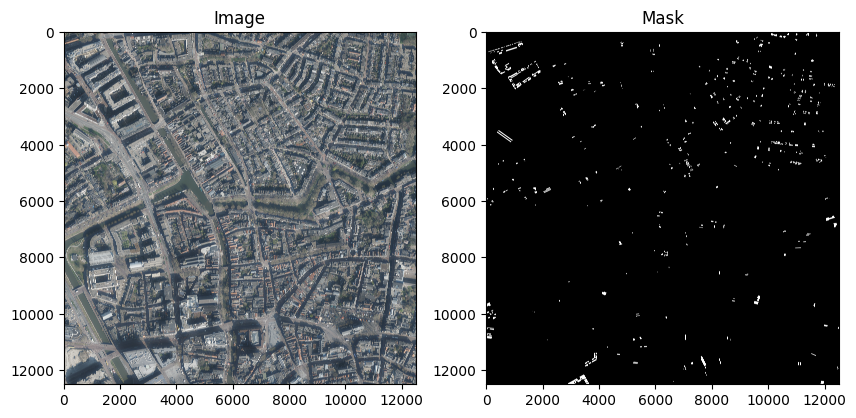

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
plt.show()

In [7]:
def divide_into_patches(image, mask, patch_size):
    """
    Divides an image and its mask into smaller patches.

    Parameters:
    - image: The image to be divided (numpy array).
    - mask: The corresponding mask for the image (numpy array).
    - patch_size: The size of each patch (tuple of two integers).

    Returns:
    - image_patches: A list of image patches.
    - mask_patches: A list of mask patches.
    """
    # Ensure the input dimensions are compatible
    assert image.shape[0:2] == mask.shape[0:2], "Image and mask must have the same dimensions"
    
    # Calculate the number of patches along each dimension
    patches_along_height = image.shape[0] // patch_size[0]
    patches_along_width = image.shape[1] // patch_size[1]

    image_patches = []
    mask_patches = []

    for i in range(patches_along_height):
        for j in range(patches_along_width):
            # Calculate patch coordinates
            start_row = i * patch_size[0]
            end_row = start_row + patch_size[0]
            start_col = j * patch_size[1]
            end_col = start_col + patch_size[1]

            # Extract patches
            image_patch = image[start_row:end_row, start_col:end_col]
            mask_patch = mask[start_row:end_row, start_col:end_col]

            image_patches.append(image_patch)
            mask_patches.append(mask_patch)

    return image_patches, mask_patches

In [8]:
# Desired patch size (height, width)
patch_size = (256, 256)

# Divide the image and mask into patches
image_patches, mask_patches = divide_into_patches(image, mask, patch_size)

print(f"Number of image patches: {len(image_patches)}")
print(f"Number of mask patches: {len(mask_patches)}")

Number of image patches: 2304
Number of mask patches: 2304


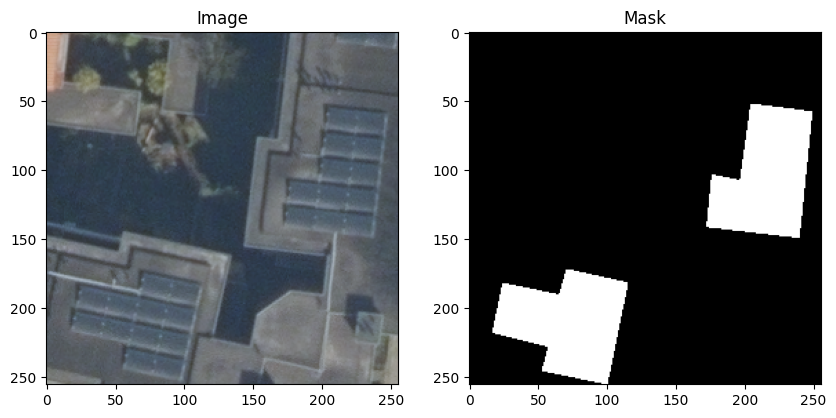

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_patches[41], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(mask_patches[41], cmap='gray')
ax[1].set_title('Mask')
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_patches, mask_patches, test_size=0.2, random_state=42)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
X_train = X_train[:10, :, :, :]
y_train = y_train[:10, :, :]

In [14]:
X_train.shape

(4, 256, 256, 3)

In [15]:
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

def downsample_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def upsample_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = downsample_block(inputs, 64)
    s2, p2 = downsample_block(p1, 128)
    s3, p3 = downsample_block(p2, 256)

    b = conv_block(p3, 512)

    d1 = upsample_block(b, s3, 256)
    d2 = upsample_block(d1, s2, 128)
    d3 = upsample_block(d2, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d3)

    model = models.Model(inputs, outputs, name="U-Net")
    return model

input_shape = (256, 256, 3)  # Example input shape, adjust to your needs
model = build_unet(input_shape)

In [16]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.BinaryCrossentropy(), 
              metrics=[metrics.BinaryAccuracy()])

In [17]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="model.keras",
    save_weights_only=False,  # Set to True to save only weights, False to save the whole model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)  # Log a message whenever the model is saved

In [19]:
# Now, include this callback in your model.fit() call
history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=1,
    validation_split=0.25,
    callbacks=[model_checkpoint_callback],  # Include the callback here
    verbose=1)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9383 - loss: 0.4739
Epoch 1: val_loss did not improve from 0.79105
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - binary_accuracy: 0.9421 - loss: 0.4669 - val_binary_accuracy: 0.0129 - val_loss: 4.1460
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9920 - loss: 0.3158
Epoch 2: val_loss did not improve from 0.79105
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - binary_accuracy: 0.9924 - loss: 0.3112 - val_binary_accuracy: 0.0312 - val_loss: 6.2279
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9998 - loss: 0.2246
Epoch 3: val_loss did not improve from 0.79105
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - binary_accuracy: 0.9997 - loss: 0.2226 - val_binary_accuracy: 0.1106 - val_loss: 2.2564


In [21]:
y_pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 181s 12s/step


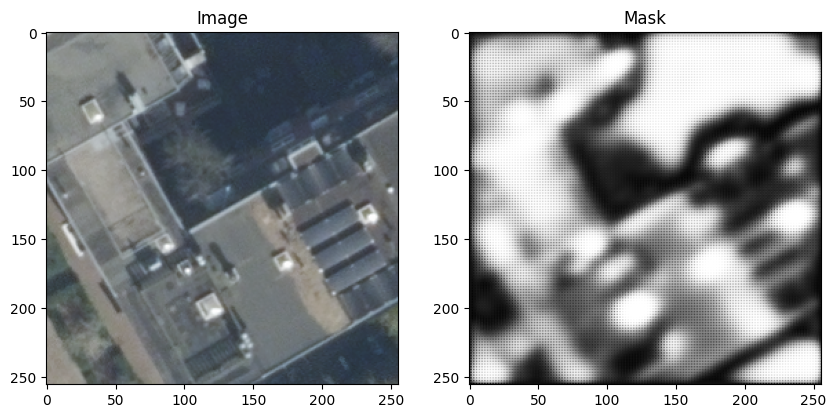

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(X_test[1], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y_pred[1], cmap='gray')
ax[1].set_title('Mask')
plt.show()